In [3]:
!pip install tqdm


     |################################| 51kB 1.6MB/s 


In [4]:
import autosklearn.regression
import sklearn.metrics
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from tqdm import tqdm
%matplotlib inline
init_notebook_mode(connected=True)

In [16]:
config = {
    "gap_scenario": '12h', # '12h', '1h', '15min',
    "random_seed": 123,
    "train_set_ratio": 0.8,
    "window_size": 10 # number of previosu values chosen for prediction
}

In [17]:
poll_path = "pollutionData158324.csv"
df_poll = pd.read_csv(poll_path, header=None, skiprows=[0],usecols=[0,7],names=['ozone', 'timestamp'])
df_poll['date'] = pd.to_datetime(df_poll['timestamp'])
df_poll = df_poll[df_poll["ozone"] > 0].reset_index(drop=True) # filter out corrupt values
df_poll = df_poll.dropna() # remove missing values
df_poll.head(2)

ozone            timestamp                date
0    101  2014-08-01 00:05:00 2014-08-01 00:05:00
1    106  2014-08-01 00:10:00 2014-08-01 00:10:00

In [18]:
df_poll.set_index('date').resample('12h').count().median()


ozone        144.0
timestamp    144.0
dtype: float64

In [19]:
gap_length = 1
# assign mean gap length per time unit
if config["gap_scenario"] == '1d':
    gap_length = 288
elif config["gap_scenario"] == '1h':
    gap_length = 12
elif config["gap_scenario"] == '12h':
    gap_length = 144
elif config["gap_scenario"] == '1min':
    gap_length = 2
    
print(f"Scenario {config['gap_scenario']}: using gap length of {gap_length}")

Scenario 12h: using gap length of 144


In [20]:
np.random.seed(config["random_seed"])
cut_start = gap_length + np.random.randint(0,gap_length)
max_idx = df_poll.shape[0]
cut_points = [x for x in range(cut_start, max_idx, gap_length)]
np.random.shuffle(cut_points)

train_test_split_p = int(len(cut_points) * config["train_set_ratio"])
train_start_idx = cut_points[:train_test_split_p]
test_start_idx = cut_points[train_test_split_p:]
train_ids = np.concatenate([np.arange(start_idx, np.min([start_idx + gap_length, max_idx])) for start_idx in train_start_idx] +
                          [np.arange(0, cut_start)])
test_ids = np.concatenate([np.arange(start_idx, np.min([start_idx + gap_length, max_idx])) for start_idx in test_start_idx])
df_train_v = df_poll.copy()
df_train_v.loc[test_ids,'date'] = np.NaN
df_test_v = df_poll.copy()
df_test_v.loc[train_ids,'date'] = np.NaN

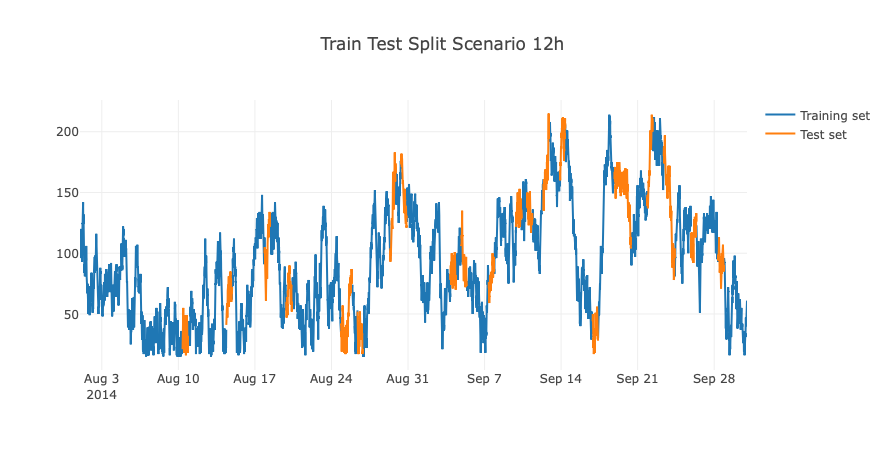

In [22]:
iplot(
    go.Figure(
        data = [go.Scatter(x=df_train_v['date'], y=df_train_v['ozone'], name='Training set'),
                go.Scatter(x=df_test_v['date'], y=df_test_v['ozone'], name='Test set')],
        layout = go.Layout(
            title = f"Train Test Split Scenario {config['gap_scenario']}")
        ))

In [25]:
def get_ml_format_df(window_size=config["window_size"]):
    df_poll_ml = df_poll.drop(["timestamp", "date"], axis=1)
    for i in range(1, window_size+1):
        df_poll_ml[f"prev_{i}"] = df_poll_ml["ozone"].shift(i)

    df_poll_ml = df_poll_ml.dropna() # do not use the first <window_size> entries for training
    return df_poll_ml
train_ids = train_ids[train_ids > config["window_size"]]
test_ids = test_ids[test_ids > config["window_size"]]
df_poll_ml = get_ml_format_df()
df_poll_ml.head(5)

ozone  prev_1  prev_2  prev_3  prev_4  prev_5  prev_6  prev_7  prev_8  \
10    115   110.0   106.0   106.0   110.0   106.0   105.0   103.0   107.0   
11    114   115.0   110.0   106.0   106.0   110.0   106.0   105.0   103.0   
12    118   114.0   115.0   110.0   106.0   106.0   110.0   106.0   105.0   
13    113   118.0   114.0   115.0   110.0   106.0   106.0   110.0   106.0   
14    114   113.0   118.0   114.0   115.0   110.0   106.0   106.0   110.0   

    prev_9  prev_10  
10   106.0    101.0  
11   107.0    106.0  
12   103.0    107.0  
13   105.0    103.0  
14   106.0    105.0

In [26]:
df_train = df_poll_ml.loc[train_ids,]
df_test = df_poll_ml.loc[test_ids,]
print(f"Effective train/test ratio is {np.round(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]), 2)}")

x_train = df_train.drop("ozone", axis=1)
Y_train = df_train["ozone"]
x_test = df_test.drop("ozone", axis=1)
Y_test = df_test["ozone"]

Effective train/test ratio is 0.79


In [27]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

In [28]:

# baselines
# always mean
print("Baselines...")
print("Always mean, MAPE score:", mean_absolute_percentage_error(Y_test, np.repeat(Y_train.mean(), Y_test.shape[0])))
print("Always mean, MSE score:", mean_squared_error(Y_test, np.repeat(Y_train.mean(), Y_test.shape[0])))
print("Always mean, RMSE score:", mean_squared_error(Y_test, np.repeat(Y_train.mean(), Y_test.shape[0])) ** 0.5)
print("Always median, MAPE score:", mean_absolute_percentage_error(Y_test, np.repeat(Y_train.median(), Y_test.shape[0])))
print("Always median, MSE score:", mean_squared_error(Y_test, np.repeat(Y_train.median(), Y_test.shape[0])))
print("Always median, RMSE score:", mean_squared_error(Y_test, np.repeat(Y_train.median(), Y_test.shape[0])) ** 0.5)
print("Always previous, MAPE score:", mean_absolute_percentage_error(Y_test, np.nan_to_num(Y_test.shift(1))))
print("Always previous, MSE score:", mean_squared_error(Y_test, np.nan_to_num(x_test.prev_1)))
print("Always previous, RMSE score:", mean_squared_error(Y_test, np.nan_to_num(x_test.prev_1)) ** 0.5)

Baselines...
Always mean, MAPE score: 57.25104763776543
Always mean, MSE score: 3033.0792546217062
Always mean, RMSE score: 55.073398793080734
Always median, MAPE score: 55.39205647449752
Always median, MSE score: 3327.5783333333334
Always median, RMSE score: 57.68516562629714
Always previous, MAPE score: 4.360874928815566
Always previous, MSE score: 10.336666666666666
Always previous, RMSE score: 3.2150686877058576


In [29]:
def predict_ahead(clf, x_test, window_size):
    """
    recursively predicts time series data based on previous predictions
    does so in batch-wise manner (ie previous predictions are used if x_n.prev_2==x_(n-1).prev_1)
    otherwise values passed via x_test.prev_x are used as input for prediction
    """
    if window_size < 2:
        raise Exception('window size < 2 not supported, predict directly on values')
    Y_pred = []
    cur_y_pred = [] # used to store previous predictions for current batch
    prev_x = 0
    for row in tqdm(x_test.iterrows()):
        if prev_x != row[1]['prev_2']:
            cur_y_pred = [] # detected a new batch, so clear old values
        
        # set previous value for batch detection
        prev_x = np.copy(row[1]["prev_1"])
        
        # fill values for prediction from previous predictions
        for idx, val in enumerate(cur_y_pred[:-window_size-1:-1]):
            row[1][f"prev_{idx+1}"] = val
        
        # predict based on previous predictions (or on values passed from train if no such predictions exist)
        new_pred = clf.predict(np.array(row[1].values).reshape(1, -1))
        Y_pred.append(new_pred)
        cur_y_pred.append(new_pred)
    
    return np.squeeze(Y_pred)

In [30]:
ws_mape = {}
ws_rmse = {}
ws_mse = {}

In [32]:

nr_train_values = 200 # reduce time for testing

for window_size in (25, 50, 100):
    print(f"Testing window_size of {window_size}")
    
    # feature transformation and removal of illegal train/test values
    iter_train_ids = train_ids[train_ids > window_size]
    iter_test_ids = test_ids[test_ids > window_size]
    df_energy_ml = get_ml_format_df(window_size)
    df_train = df_energy_ml.loc[iter_train_ids,]
    df_test = df_energy_ml.loc[iter_test_ids,]
    print(f"Effective train/test ratio is {np.round(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]), 2)}")

    x_train = df_train.drop("ozone", axis=1)
    Y_train = df_train["ozone"]
    x_test = df_test.drop("ozone", axis=1)[:nr_train_values].copy()
    Y_test = df_test["ozone"][:nr_train_values].copy()
    
    # start training
    np.random.seed(config["random_seed"]) # seed again for multiple executions within notebook
    feature_types = ["Numerical" for x in x_train.columns]
    automl = autosklearn.regression.AutoSklearnRegressor(
            time_left_for_this_task=1800,
            per_run_time_limit=600,
            seed=config["random_seed"]
        )
    automl.fit(x_train, Y_train, dataset_name="Power", feat_type=feature_types)
    
    # predict and evaluate
    print("Starting predictions..")
    predictions = automl.predict(x_test)

    ws_mse[window_size] = mean_squared_error(Y_test, predictions)
    ws_rmse[window_size] = ws_mse[window_size] ** 0.5
    ws_mape[window_size] = mean_absolute_percentage_error(Y_test, predictions)
    print("MAPE score:", ws_mape[window_size])
    print("MSE score:", ws_mse[window_size])
    print("RMSE score:", ws_mse[window_size] ** 0.5)

Testing window_size of 25
Effective train/test ratio is 0.79


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice



[WARNING] [2019-06-18 18:30:33,568:AutoMLSMBO(123)::Power] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-18 18:30:33,583:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 18:30:33,599:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 18:30:35,623:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 18:30:37,629:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 18:30:39,635:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 18:30:41,645:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/loc

Starting predictions..
MAPE score: 4.685484119002444
MSE score: 12.641864566218088
RMSE score: 3.5555399823680913
Testing window_size of 50
Effective train/test ratio is 0.79


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice



[WARNING] [2019-06-18 19:00:30,063:AutoMLSMBO(123)::Power] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-18 19:00:30,077:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:30,090:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:32,101:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:34,108:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:36,115:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:38,123:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:00:40,132:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/loc

Starting predictions..
MAPE score: 5.092148316130142
MSE score: 16.405064054375813
RMSE score: 4.05031653755306
Testing window_size of 100
Effective train/test ratio is 0.79


/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice



[WARNING] [2019-06-18 19:30:26,514:AutoMLSMBO(123)::Power] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-06-18 19:30:26,516:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:26,531:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:28,537:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:30,553:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:32,562:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:34,567:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:30:36,582:EnsembleBuilder(123):Power] No models better than random - using Dummy Score!
[WARNING] [2019-06-18 19:

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning:

Mean of empty slice

/usr/loc

Starting predictions..
MAPE score: 5.2297225018482045
MSE score: 19.72721194728391
RMSE score: 4.441532612430524


In [33]:
ws_mape



{25: 4.685484119002444, 50: 5.092148316130142, 100: 5.2297225018482045}

In [34]:
ws_mse



{25: 12.641864566218088, 50: 16.405064054375813, 100: 19.72721194728391}

In [35]:
ws_rmse


{25: 3.5555399823680913, 50: 4.05031653755306, 100: 4.441532612430524}

In [41]:
df_metrics = pd.DataFrame.from_dict(ws_mape, orient='index', columns=['mape'])\
.join(pd.DataFrame.from_dict(ws_rmse, orient='index', columns=['rmse']))\
.join(pd.DataFrame.from_dict(ws_mse, orient='index', columns=['mse']))

df_metrics.to_csv(f"poll_gl{gap_length}_metrics.csv")
df_metrics

mape      rmse        mse
25   4.685484  3.555540  12.641865
50   5.092148  4.050317  16.405064
100  5.229723  4.441533  19.727212

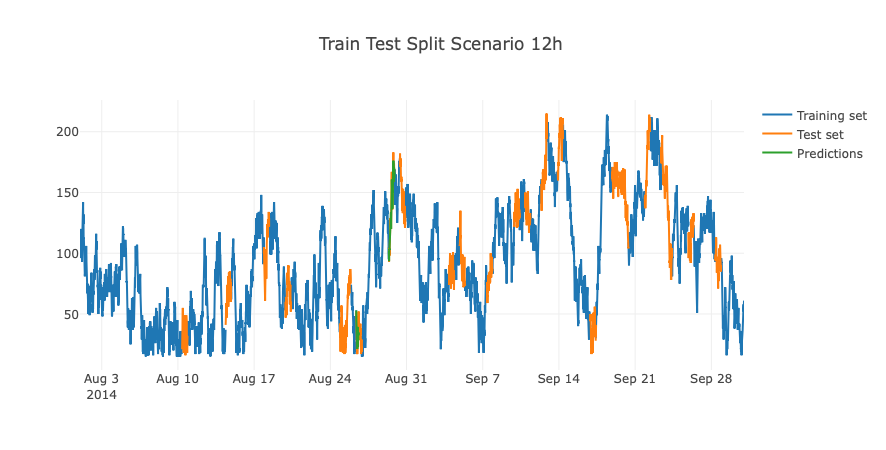

In [40]:
df_test_p = df_test_v.copy()
df_test_p.loc[test_ids[:200],'pred'] = predictions
iplot(
    go.Figure(
        data = [go.Scatter(x=df_train_v['date'], y=df_train_v['ozone'], name='Training set'),
                go.Scatter(x=df_test_v['date'], y=df_test_v['ozone'], name='Test set'),
                go.Scatter(x=df_test_p['date'], y=df_test_p['pred'], name='Predictions')],
        layout = go.Layout(
            title = f"Train Test Split Scenario {config['gap_scenario']}")
        ))

In [42]:
df_metrics_288 = pd.read_csv("poll_gl288_metrics.csv", index_col=0)
df_metrics_144 = pd.read_csv("poll_gl144_metrics.csv", index_col=0)
df_metrics_12 = pd.read_csv("poll_gl12_metrics.csv", index_col=0)


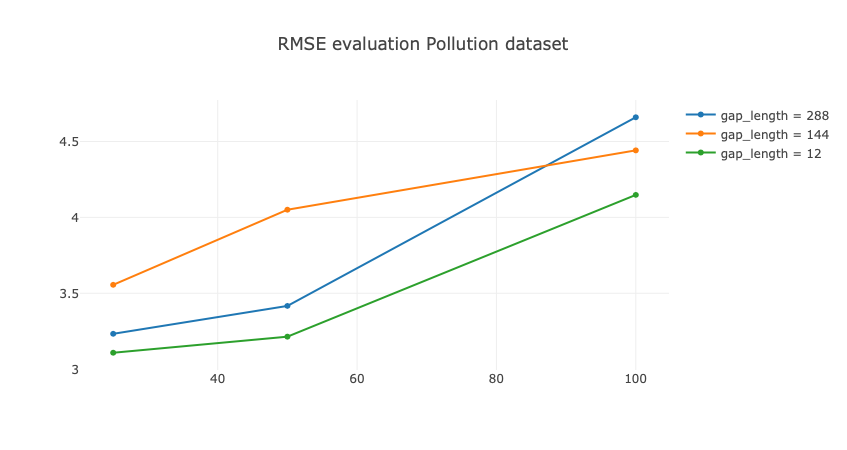

In [44]:
iplot(
    go.Figure(
        data = [go.Scatter(x=df_metrics_288.index, y=df_metrics_288.rmse, name="gap_length = 288"),
                go.Scatter(x=df_metrics_144.index, y=df_metrics_144.rmse, name="gap_length = 144"),
                go.Scatter(x=df_metrics_12.index, y=df_metrics_12.rmse, name="gap_length = 12")],
        layout = go.Layout(
            title = f"RMSE evaluation Pollution dataset")
        ))

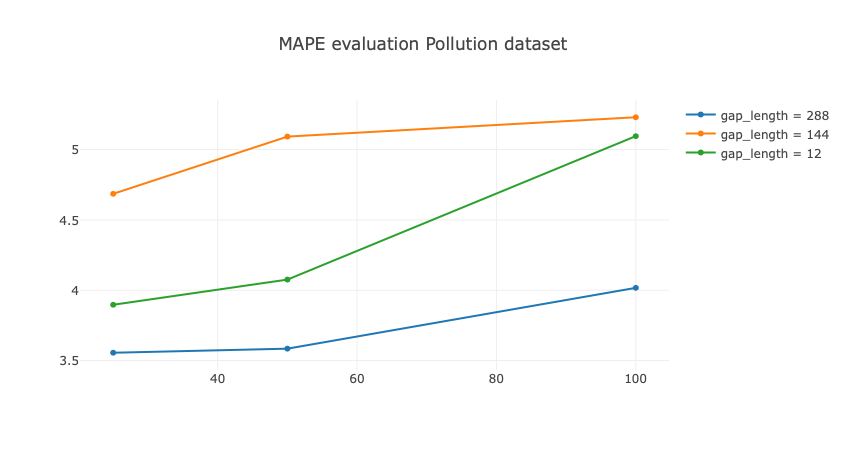

In [45]:
iplot(
    go.Figure(
        data = [go.Scatter(x=df_metrics_288.index, y=df_metrics_288.mape, name="gap_length = 288"),
                go.Scatter(x=df_metrics_144.index, y=df_metrics_144.mape, name="gap_length = 144"),
                go.Scatter(x=df_metrics_12.index, y=df_metrics_12.mape, name="gap_length = 12")],
        layout = go.Layout(
            title = f"MAPE evaluation Pollution dataset")
        ))